The idea is to hvae a agent playing against another one and using the data (buffer ) generated to train the policy/value nn

In [14]:
from src.drl.game import Game, TicTacToe 
from src.drl.tictactoe_solver import TicTacToeLookUpSolver

In [15]:
import os
#os.chdir('../src/drl/')
#from game import Game, TicTacToe
import random
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.utils.validation import check_is_fitted
import numpy as np

In [65]:

class RLAgent:
    """Representation of the agent that will play the game"""
    def __init__(self, model, game, ratio_explotation_exploration):
        self.model = model
        self.model_is_fitted = False
        self.game = game
        self.columns = [f"s_{x}" for x in range(len(self.game.action_space))]
        self.cont = 0
        self.ratio_explotation_exploration = ratio_explotation_exploration
        
    def choose_action(self, actions, list_states, player, force_model_prediction=False):
        """Choose action from current possible actions """
        if ((self.model_is_fitted) and ((self.cont % self.ratio_explotation_exploration) != 0)) or force_model_prediction :
            if player==-1:
                list_states = [invert_state(list_1) for list_1 in list_states]
            model_action_max=np.argmax(self.model.predict(pd.DataFrame(list_states, columns=self.columns)))
            action = actions[model_action_max]
        else:
            action = random.choice(actions)
            
        self.cont+=1
        return action
        
class RLSimulation:
    """Representation of the game simulation"""
    def __init__(
         self,
         n_games: int,
         game: Game,
         agent: RLAgent
    ):
        self.n_games = n_games
        self.game = game
        self.agent = agent
        
    def run_simulations(self,):
        processed_buffer=[]
        for _ in range(self.n_games):
            buffer = self.run()
            processed_buffer.append(self.process_buffer(buffer))
            
        return processed_buffer
        
    def run(self,):
        """Run one game and return outcome and buffer from the game (history of states)"""
        self.game.reset()
        buffer_one_game = []
        while True:
            actions = self.game._get_possible_actions(state=self.game.board)
            next_states_list = self.game._get_possible_next_states(state=self.game.board)
            action = self.agent.choose_action(actions, next_states_list, player=self.game.player)
            outcome = self.game.play(action=action)

            # the game player is inverted because once the movement is done, the player change
            buffer_one_game.append((action, self.game.board, outcome, -self.game.player))
            if outcome is not None:
                break
        return buffer_one_game
    
    def process_buffer(self, buffer: list):
        """ We want to process the buffer from one game. How? Give the reward to player that ended 
        the game and invert the state since we will consider the model only from the perspective of the player one"""

        # TODO: there must be a simplest way of doing it
        last_action, last_state, last_reward, last_player = buffer[-1]
        if last_reward == 0.5:
            # reward is value
            buffer_processed = [(state, last_reward) if player==1 else (invert_state(state), last_reward) for (action, state, value, player) in buffer  ]

        elif last_reward == 1 and last_player==1:
            buffer_processed = [(state, last_reward) if player==1 else (invert_state(state), 1-last_reward) for (action, state, value, player) in buffer  ]

        elif last_reward == 1 and last_player==-1:
            buffer_processed = [(state, 1-last_reward) if player==1 else (invert_state(state), last_reward) for (action, state, value, player) in buffer  ]

        else:
            raise ValueError("something went wrong in buffer processing")
            
        return buffer_processed
            
        
        
class Trainer:
    """Representation of training"""
    def __init__(self, n_simulations: int, sim: RLSimulation):
        self.n_simulations = n_simulations
        self.sim = sim
        self.training_buffer = pd.DataFrame()
        self.all_buffer = pd.DataFrame()
        self.score=[]
        self.win_lost_tie = []
    def main(self):
        for n in range(self.n_simulations):
            self.training_buffer = self.from_buffer_to_df(self.sim.run_simulations())
            self.train()

            self.update_all_buffer()
            if n%5==0:
                self.evaluate()
    def train(self):
        print("training")

        sim.agent.model.fit(X=self.training_buffer[self.sim.agent.columns], y=self.training_buffer["value"])
        if not sim.agent.model_is_fitted:
            sim.agent.model_is_fitted = True
            
    def evaluate(self,):
        score = agent.model.score(X=self.all_buffer[self.sim.agent.columns],y=self.all_buffer["value"])
        #print(score)
        self.score.append(score)
        # Plus running against lookup
        playerLU = TicTacToeLookUpSolver(path="../tictactoe_solver.json")
        win = 0
        lost = 0
        tie = 0
        for game_n in range(5): 
            game=TicTacToe()
            game.reset()
            for n in range(5):

                game.play(playerLU.play(state=game.board, difficulty=10))
                #game.render_table()
                if game._is_win():
                    lost +=1
                    break
                elif n==4:
                    tie+=1
                    break

                game.play(get_action(game, self.sim.agent))
                if game._is_win():
                    win+=1
                    break
                #game.render_table()
        print("win, lost, tie", win, lost, tie)
        self.win_lost_tie.append([win, lost, tie])
        
        
            
    def from_buffer_to_df(self,buffer):
        buffer = [state for buffer_ind in buffer for state in buffer_ind  ]
        buffer_df=pd.DataFrame(buffer, columns=["state", "value"])
        #df_out = pd.DataFrame()
        buffer_df[self.sim.agent.columns] = pd.DataFrame(buffer_df.state.tolist(), index = buffer_df.index)
        return buffer_df
    
    def update_all_buffer(self):
        self.all_buffer = pd.concat([self.all_buffer, self.training_buffer])


        
        
def get_action(game, agent):
    actions = game._get_possible_actions(state=game.board)
    next_states_list = game._get_possible_next_states(state=game.board)
    action = agent.choose_action(actions, next_states_list, player=game.player, force_model_prediction=True)
    return action
    
def invert_state(state):
    """From the perspective of player 1"""
    #if sum(np.array(state))!=0:
    state=[-x for x in state]
    return state

In [54]:
10%2

0

In [79]:
# 20,20  2 200 200 
model = MLPRegressor(
            hidden_layer_sizes=(30,30),
            random_state=1, n_iter_no_change=10000, tol=1e-7,
            max_iter=100, verbose=False,
            warm_start=True)
#game = Connect2()
game = TicTacToe()
agent = RLAgent(model=model, game=game, ratio_explotation_exploration=2)
sim = RLSimulation(n_games=500, game=game, agent= agent)
trainer = Trainer(n_simulations=50, sim=sim)

In [ ]:
trainer.main()

training


/Users/pablocanadapereira/opt/anaconda3/envs/datascience/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


win, lost, tie 0 5 0
training
training


In [6]:
game.reset()
game.play_mcts(6)
game.render()
game.play_mcts(0)
game.render()
game.play_mcts(7)
game.render()
game.play_mcts(1)
game.render()
game.play_mcts(3)
game.render()
game.play_mcts(2)
game.render()

[0, 0, 0, 0, 0, 0, 1, 0, 0] Next player: -1
[-1, 0, 0, 0, 0, 0, 1, 0, 0] Next player: 1
[-1, 0, 0, 0, 0, 0, 1, 1, 0] Next player: -1
[-1, -1, 0, 0, 0, 0, 1, 1, 0] Next player: 1
[-1, -1, 0, 1, 0, 0, 1, 1, 0] Next player: -1
[-1, -1, -1, 1, 0, 0, 1, 1, 0] Next player: 1


training


/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


NameError: name 'TicTacToeLookUpSolver' is not defined

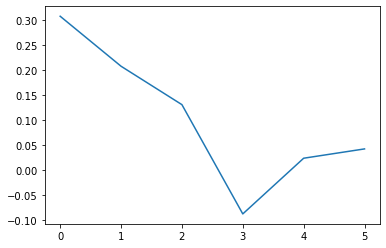

In [5]:
import matplotlib.pyplot  as plt
plt.plot(trainer.score)
#plt.ylim(0,1)

In [68]:
import pickle
with open(f"tictactoe_trainer_4.pickle", "wb") as f:
    # avoid api key to be serialized
    pickle.dump(trainer, f)

In [38]:
trainer.all_buffer

,state,value,s_0,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8
0,"[0, 0, 0, 0, 0, 0, 1, 0, 0]",1.0,0,0,0,0,0,0,1,0,0
1,"[0, 0, 0, 0, 0, 0, -1, 0, 1]",0.0,0,0,0,0,0,0,-1,0,1
2,"[1, 0, 0, 0, 0, 0, 1, 0, -1]",1.0,1,0,0,0,0,0,1,0,-1
3,"[-1, 0, 0, 0, 0, 0, -1, 1, 1]",0.0,-1,0,0,0,0,0,-1,1,1
4,"[1, 0, 0, 1, 0, 0, 1, -1, -1]",1.0,1,0,0,1,0,0,1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...
343,"[1, 0, 0, -1, 1, 0, -1, 0, 0]",1.0,1,0,0,-1,1,0,-1,0,0
344,"[-1, 0, 1, 1, -1, 0, 1, 0, 0]",0.0,-1,0,1,1,-1,0,1,0,0
345,"[1, 0, -1, -1, 1, 0, -1, 1, 0]",1.0,1,0,-1,-1,1,0,-1,1,0
346,"[-1, 0, 1, 1, -1, 1, 1, -1, 0]",0.0,-1,0,1,1,-1,1,1,-1,0


<AxesSubplot:>

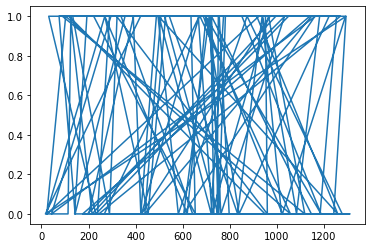

In [28]:
trainer.all_buffer[trainer.all_buffer.state.isin([[-1, -1, 0, 0, 0, 0, 1, 0, 1]])].value.hist()

In [14]:
#df_test = pd.DataFrame([[0,0,0,1],[0,1,0,0], [0,0,1,0], [0,0,0,1]])
#df_test = pd.DataFrame([[0,0,-1,1],[0,1,-1,0], [0,-1,1,0], [-1,0,0,1]])
df_test = pd.DataFrame([[-1, -1, 1, 0, 0, 0, 1, 0, 0],[-1, -1, 0, 1, 0, 0, 1, 0, 0],[-1, -1, 0, 0, 0, 0, 1, 0, 1]])
agent.model.predict(df_test)

array([0.23956717, 0.0691996 , 0.80907971])

In [8]:
def get_action(game, agent):
    actions = game._get_possible_actions(state=game.board)
    next_states_list = game._get_possible_next_states(state=game.board)
    action = agent.choose_action(actions, next_states_list, player=game.player, force_model_prediction=True)
    return action

In [37]:
#lets play


In [51]:
# interesting 4, 3, 6, 1
# 4,2,7,1
playerAI = TicTacToeLookUpSolver(path="../tictactoe_solver.json")
game=TicTacToe()
game.reset()
while True:
    game.play(playerAI.play(state=game.board, difficulty=10))
    game.render_table()
    game.play(get_action(game, trainer.sim.agent))
    game.render_table()


[[0 0 0]
 [1 0 0]
 [0 0 0]] Next player: -1
[[ 0  0  0]
 [ 1 -1  0]
 [ 0  0  0]] Next player: 1
[[ 0  0  1]
 [ 1 -1  0]
 [ 0  0  0]] Next player: -1
[[ 0 -1  1]
 [ 1 -1  0]
 [ 0  0  0]] Next player: 1
[[ 0 -1  1]
 [ 1 -1  0]
 [ 0  1  0]] Next player: -1
[[-1 -1  1]
 [ 1 -1  0]
 [ 0  1  0]] Next player: 1
[[-1 -1  1]
 [ 1 -1  0]
 [ 0  1  1]] Next player: -1
[[-1 -1  1]
 [ 1 -1  0]
 [-1  1  1]] Next player: 1
[[-1 -1  1]
 [ 1 -1  1]
 [-1  1  1]] Next player: -1


ValueError: Found array with 0 sample(s) (shape=(0, 9)) while a minimum of 1 is required.

In [53]:
get_action(game, trainer.sim.agent)

8

In [76]:
test_buffer_draw = [(0, [1, 0, 0, 0], None, 1), (1, [1, -1, 0, 0], None, -1), (2, [1, -1, 1, 0], None, 1), (3, [1, -1, 1, -1], 0.5, -1)]
test_buffer_win_player_1 = [(3, [0, 0, 0, 1], None, 1), (0, [-1, 0, 0, 1], None, -1), (2, [-1, 0, 1, 1], 1, 1)]
test_buffer_win_player_m1 = [(3, [0, 0, 0, 1], None, 1), (1, [0, -1, 0, 1], None, -1), (0, [1, -1, 0, 1], None, 1), (2, [1, -1, -1, 1], 1, -1)]

In [87]:
process_buffer(test_buffer_draw)

[([1, 0, 0, 0], 0.5),
 ([-1, 1, 0, 0], 0.5),
 ([1, -1, 1, 0], 0.5),
 ([-1, 1, -1, 1], 0.5)]

In [88]:
process_buffer(test_buffer_win_player_1)

[([0, 0, 0, 1], 1), ([1, 0, 0, -1], 0), ([-1, 0, 1, 1], 1)]

In [89]:
process_buffer(test_buffer_win_player_m1)

[([0, 0, 0, 1], 0),
 ([0, 1, 0, -1], 1),
 ([1, -1, 0, 1], 0),
 ([-1, 1, 1, -1], 1)]

In [11]:
#buffer processing
import numpy as np
def invert_state(state):
    """From the perspective of player 1"""
    #if sum(np.array(state))!=0:
    state=[-x for x in state]
    return state

def from_buffer_to_df(buffer):from_sta
    buffer_df=pd.DataFrame(buffer, columns=["action_taken", "state", "reward", "player"])
    return handle_reward(buffer_df)

def from_state_to_column(df):
    assert "state" in df.columns
    df_out=pd.DataFrame()
    columns = [f"s_{x}" for x in range(len(df.state.iloc[0]))]
    df_out[columns] = pd.DataFrame(df.state.tolist(), index= df.index)
    
    return df_out, columns

def from_state_to_columns_model_pred(lists):
    pass


def handle_reward(df):
    df = df.copy()
    mask_not_null_reward = df.reward.notnull()
    mask_null_reward = df.reward.isnull()
    
    # invert state
    df.loc[(df.player==-1),"state"] = df[(df.player==-1)].state.apply(invert_state)
    
    if df[mask_not_null_reward].reward.values==0.5:
        df.loc[mask_null_reward, "reward"]=0.5
        
    elif df[mask_not_null_reward].reward.values!=0.5:
        reward = df[mask_not_null_reward].reward.values[0]
        #print(reward)
        player = df[mask_not_null_reward].player.values[0]
        #print(player)
        
        df.loc[(mask_null_reward) &
               (df.player==player)
               , "reward"]=reward
        
        df.loc[(mask_null_reward) &
               (df.player==-player)
               , "reward"]=1-reward
        
        # and invert state

        
    return df
    

In [9]:
columns = [f"s_{x}" for x in range(4)]

In [62]:
10%3

1

In [12]:
game = Connect2()

In [76]:

model = MLPRegressor(
hidden_layer_sizes=(10,10),
random_state=1, n_iter_no_change=100, tol=1e-5,
max_iter=100, verbose=True,
warm_start=True)


buffer_total = []
model_action_max = None
for j in range(4):
    df_buffer = pd.DataFrame()
    for i in range(1000):
        game.reset()
        buffer = []
        while True:

            #random_action = random.choice(game._get_possible_actions(state=game.board))
            actions = game._get_possible_actions(state=game.board)


            lists=game._get_possible_next_states(state=game.board)
            #print("lists", lists)
            #print("player to play", game.player)
            if game.player==-1:
                lists = [invert_state(list_1) for list_1 in lists]
                #print("inverted list", lists)
            
            #print(actions)
            #print(model_action_max)
            if j!=0 and i%3==0:
                # select model prediction 2/3 of the time
                model_action_max=np.argmax(model.predict(pd.DataFrame(lists, columns=columns)))
                action = actions[model_action_max]
                outcome = game.play_mcts(action=action)
            else:
                
                action = random.choice(game._get_possible_actions(state=game.board))
                outcome = game.play_mcts(action=action)
            #random_action)
            buffer.append((action, game.board, outcome, -game.player))
            buffer_total.append((action, game.board, outcome, -game.player))
            #game.render()
            #print(outcome)
            if outcome is not None:
                df_aux = from_buffer_to_df(buffer)
                df_buffer = pd.concat([df_buffer, df_aux]).copy()
                #print(outcome)
                break


    df_train, columns = from_state_to_column(df_buffer.copy())
    df_train["target"] =df_buffer["reward"]

    X, y = df_train[columns], df_train["target"]
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=1)
    model.fit(X=X_train, y=y_train)
    print(model.score(X_test, y_test))
            

            
            
    


Iteration 1, loss = 0.39120418
Iteration 2, loss = 0.28313229
Iteration 3, loss = 0.20483682
Iteration 4, loss = 0.14696199
Iteration 5, loss = 0.10807168
Iteration 6, loss = 0.08463739
Iteration 7, loss = 0.07182294
Iteration 8, loss = 0.06514716
Iteration 9, loss = 0.06128333
Iteration 10, loss = 0.05846352
Iteration 11, loss = 0.05619863
Iteration 12, loss = 0.05452144
Iteration 13, loss = 0.05319640
Iteration 14, loss = 0.05210811
Iteration 15, loss = 0.05113448
Iteration 16, loss = 0.05025124
Iteration 17, loss = 0.04947765
Iteration 18, loss = 0.04879712
Iteration 19, loss = 0.04819530
Iteration 20, loss = 0.04770632
Iteration 21, loss = 0.04723464
Iteration 22, loss = 0.04683178
Iteration 23, loss = 0.04643247
Iteration 24, loss = 0.04605457
Iteration 25, loss = 0.04566560
Iteration 26, loss = 0.04530105
Iteration 27, loss = 0.04501121
Iteration 28, loss = 0.04465977
Iteration 29, loss = 0.04436737
Iteration 30, loss = 0.04405358
Iteration 31, loss = 0.04376260
Iteration 32, los

/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 101, loss = 0.03439821
Iteration 102, loss = 0.03115882
Iteration 103, loss = 0.02943547
Iteration 104, loss = 0.02835577
Iteration 105, loss = 0.02780472
Iteration 106, loss = 0.02742269
Iteration 107, loss = 0.02713278
Iteration 108, loss = 0.02693264
Iteration 109, loss = 0.02672289
Iteration 110, loss = 0.02650252
Iteration 111, loss = 0.02629870
Iteration 112, loss = 0.02609235
Iteration 113, loss = 0.02592589
Iteration 114, loss = 0.02576803
Iteration 115, loss = 0.02562703
Iteration 116, loss = 0.02550045
Iteration 117, loss = 0.02537706
Iteration 118, loss = 0.02528635
Iteration 119, loss = 0.02513762
Iteration 120, loss = 0.02504146
Iteration 121, loss = 0.02491159
Iteration 122, loss = 0.02484499
Iteration 123, loss = 0.02474301
Iteration 124, loss = 0.02462730
Iteration 125, loss = 0.02454270
Iteration 126, loss = 0.02448574
Iteration 127, loss = 0.02439529
Iteration 128, loss = 0.02430334
Iteration 129, loss = 0.02421348
Iteration 130, loss = 0.02421706
Iteration 

In [77]:
df_train

,s_0,s_1,s_2,s_3,target
0,0,1,0,0,1.0
1,0,-1,1,0,0.0
2,1,1,-1,0,1.0
0,0,1,0,0,0.5
1,0,-1,1,0,0.5
...,...,...,...,...,...
1,0,1,-1,0,0.0
2,0,-1,1,1,1.0
0,0,1,0,0,1.0
1,0,-1,1,0,0.0


In [65]:
df_train

,s_0,s_1,s_2,s_3,target
0,0,1,0,0,1.0
1,0,-1,1,0,0.0
2,1,1,-1,0,1.0
0,0,0,0,1,1.0
1,1,0,0,-1,0.0
...,...,...,...,...,...
1,0,0,-1,1,0.0
2,0,1,1,-1,1.0
0,0,1,0,0,1.0
1,0,-1,1,0,0.0


In [74]:
buffer

[(1, [0, 1, 0, 0], None, 1),
 (0, [-1, 1, 0, 0], None, -1),
 (2, [-1, 1, 1, 0], 1, 1)]

In [52]:
actions = game._get_possible_actions(state=game.board)


In [53]:
    lists=game._get_possible_next_states(state=game.board)

In [54]:
lists

[[-1, 1, 1, -1]]

In [49]:
pd.DataFrame(data=[[0,0,0,0]], columns=columns)

,s_0,s_1,s_2,s_3
0,0,0,0,0


In [67]:
df_buffer

,action_taken,state,reward,player
0,1,"[0, 1, 0, 0]",1.0,1
1,1,"[0, -1, 1, 0]",0.0,-1
2,0,"[1, 1, -1, 0]",1.0,1
0,0,"[0, 0, 0, 1]",1.0,1
1,0,"[1, 0, 0, -1]",0.0,-1
...,...,...,...,...
1,0,"[0, 0, -1, 1]",0.0,-1
2,0,"[0, 1, 1, -1]",1.0,1
0,1,"[0, 1, 0, 0]",1.0,1
1,1,"[0, -1, 1, 0]",0.0,-1


In [60]:
df_train

,s_0,s_1,s_2,s_3,target
0,0,1,0,0,1.0
1,0,-1,1,0,0.0
2,1,1,-1,0,1.0
0,0,1,0,0,1.0
1,0,-1,1,0,0.0
...,...,...,...,...,...
1,0,-1,1,0,0.0
2,1,1,-1,0,1.0
0,0,1,0,0,1.0
1,0,-1,1,0,0.0


In [82]:
model.predict(pd.DataFrame(data=[ [1,0,0,0], [0,1,0,0], [0,0,1,0], [0,0,0,1]], columns=columns))

array([0.51815877, 0.92339669, 0.782936  , 0.48675461])

In [85]:
game.reset()
actions=game._get_possible_actions(state=game.board)
print(actions)
lists=game._get_possible_next_states(state=game.board)
print(lists)

[0 1 2 3]
[[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]


In [86]:
model.predict(pd.DataFrame(lists, columns=columns))

array([ 0.13850045,  0.07148037,  0.34122707, -0.07563337])

In [87]:
game.play_mcts(action=0)

In [88]:
game.render()

[1, 0, 0, 0] Next player: -1


In [89]:
lists=game._get_possible_next_states(state=game.board)
print(lists)

[[1, -1, 0, 0], [1, 0, -1, 0], [1, 0, 0, -1]]


In [90]:
model.predict(pd.DataFrame(lists, columns=columns))

array([ 0.09925521, -0.09809519,  0.16684824])

In [34]:
actions = game._get_possible_actions(state=game.board)
print(actions)       

[0 1 2 3]


In [37]:
actions[2]

2

In [35]:
model.predict(pd.DataFrame(lists, columns=columns))

array([0.48167117, 0.61069045, 0.73385697, 0.39945526])

In [36]:
np.argmax(model.predict(pd.DataFrame(lists, columns=columns)))

2

In [23]:
np.argmax(model.predict(pd.DataFrame(lists, columns=columns)))

2

In [73]:
df_train["preds"] = model.predict(df_train[columns])

In [74]:
df_train

,s_0,s_1,s_2,s_3,target,preds
0,0,0,0,1,1.0,0.366677
1,1,0,0,-1,0.0,0.416638
2,-1,0,1,1,1.0,0.997187
0,0,0,1,0,1.0,0.779708
1,0,0,-1,1,0.0,0.066556
2,0,1,1,-1,1.0,1.123449
0,1,0,0,0,0.5,0.349925
1,-1,0,0,1,0.5,0.630562
2,1,0,1,-1,0.5,0.628422
3,-1,1,-1,1,0.5,0.281643


In [12]:
#buffer processing
import numpy as np
def invert_state(state):
    """From the perspective of player 1"""
    #if sum(np.array(state))!=0:
    state=[-x for x in state]
    return state

def from_buffer_to_df(buffer):
    buffer_df=pd.DataFrame(buffer, columns=["action_taken", "state", "reward", "player"])
    return handle_reward(buffer_df)

def from_state_to_column(df):
    assert "state" in df.columns
    df_out=pd.DataFrame()
    columns = [f"s_{x}" for x in range(len(df.state.iloc[0]))]
    df_out[columns] = pd.DataFrame(df.state.tolist(), index= df.index)
    
    return df_out, columns

def from_state_to_columns_model_pred(lists):


def handle_reward(df):
    df = df.copy()
    mask_not_null_reward = df.reward.notnull()
    mask_null_reward = df.reward.isnull()
    
    # invert state
    df.loc[(df.player==-1),"state"] = df[(df.player==-1)].state.apply(invert_state)
    
    if df[mask_not_null_reward].reward.values==0.5:
        df.loc[mask_null_reward, "reward"]=0.5
        
    elif df[mask_not_null_reward].reward.values!=0.5:
        reward = df[mask_not_null_reward].reward.values[0]
        #print(reward)
        player = df[mask_not_null_reward].player.values[0]
        #print(player)
        
        df.loc[(mask_null_reward) &
               (df.player==player)
               , "reward"]=reward
        
        df.loc[(mask_null_reward) &
               (df.player==-player)
               , "reward"]=1-reward
        
        # and invert state

        
    return df
    

In [61]:
buffer_df=pd.DataFrame(buffer, columns=["action_taken", "state", "reward", "player"])

In [50]:
df_train.state.iloc[0]

[0, 0, 1, 0]

In [51]:
columns = [f"s_{x}" for x in range(len(df_train.state.iloc[0]))]

In [52]:
columns

['s_0', 's_1', 's_2', 's_3']

In [56]:
from_state_to_column(df_train)

,s_0,s_1,s_2,s_3
0,0,0,1,0
1,1,0,-1,0
2,-1,1,1,0
0,0,0,1,0
1,0,1,-1,0
2,0,-1,1,1
0,0,1,0,0
1,0,-1,0,1
2,1,1,0,-1
0,0,0,0,1


In [58]:
buffer_df.iloc[17:21][(buffer_df.iloc[17:21].player==-1)].state.values[0]

[1, 0, -1, 0]

In [54]:
buffer_df.iloc[17:21][(buffer_df.iloc[17:21].player==-1)].state.apply(invert_state)

18     [1, 0, -1, 0]
20    [1, -1, -1, 1]
Name: state, dtype: object

In [63]:
handle_reward(buffer_df.iloc[17:21])

1.0
-1


,action_taken,state,reward,player
17,0,"[1, 0, 0, 0]",0.0,1
18,2,"[-1, 0, 1, 0]",1.0,-1
19,3,"[1, 0, -1, 1]",0.0,1
20,1,"[-1, 1, 1, -1]",1.0,-1


In [50]:
buffer_df_aux.loc[buffer_df_aux.reward==0.5]

,action_taken,state,reward,player
3,0,"[-1, 1, -1, 1]",0.5,-1


In [ ]:

class Simulation:
    def __init__(self,):
        self.model = 